# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [5]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


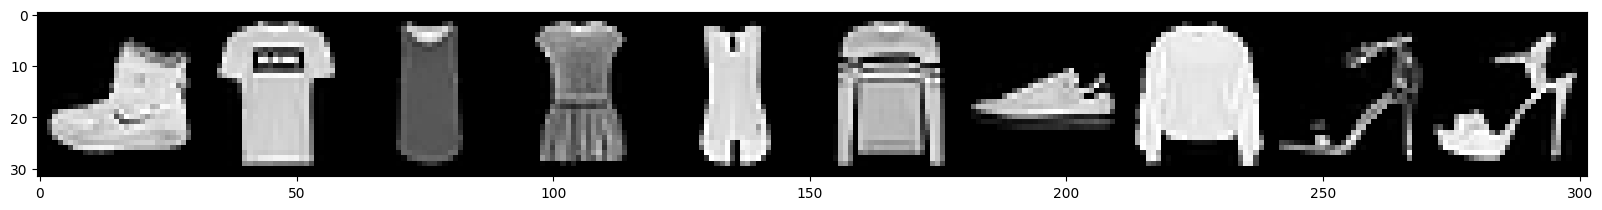

In [6]:
x = [train_dataset[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # self.conv3 = nn.Conv2d(64, 128, 3, 1) # learns more abstract things e.g. objects than conv1 and conv2
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(9216, 2048) # full layer is 25088
        self.fc2 = nn.Linear(2048, 128) # full layer is 25088
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 12x12x64

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        return x # raw logits - log-softmax not neccessary, because corss-entropy account for it



In [11]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader): # target label - ground truth
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            data_processed_so_far = batch_idx * len(data)
            total_data = len(train_loader.dataset)
            progress = 100. * batch_idx / len(train_loader)

            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, data_processed_so_far, total_data, progress, loss.item()
            ), end="\r")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0.
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    total_data = len(test_loader.dataset)
    test_loss /= total_data
    progress = 100. * correct / total_data

    print("Test Set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, total_data, progress
    ), end="\r")


In [ ]:
from torch.optim.lr_scheduler import StepLR

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 10
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

KeyboardInterrupt: 

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [212]:
train_dataset = NoisyFashionMNIST("./data", True)
test_dataset = NoisyFashionMNIST("./data", False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3924341..1.2826629].


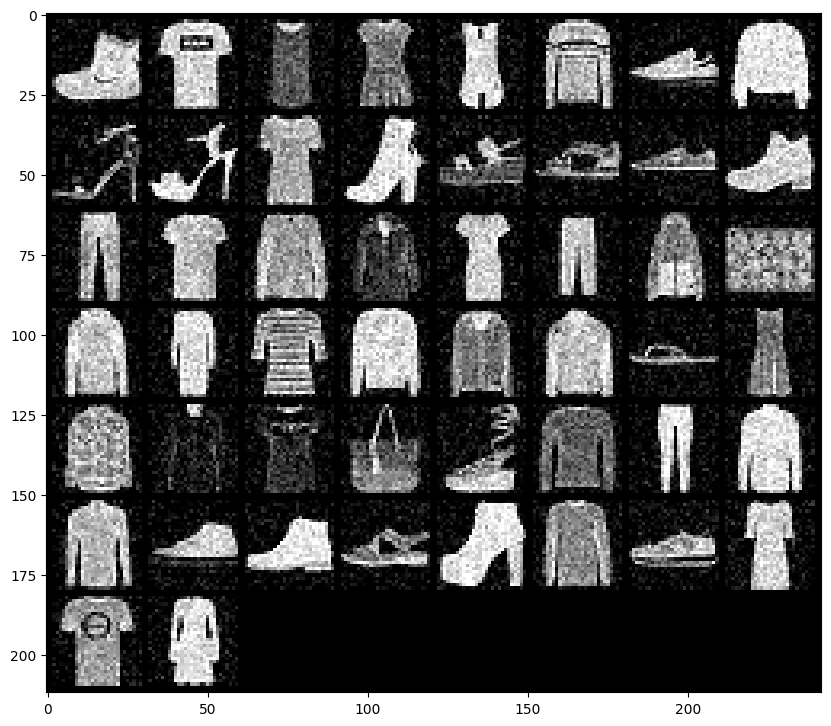

In [186]:
x = [train_dataset[i][0] for i in range(50)]
y = [train_dataset[i][1] for i in range(50)]
plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

# plt.figure(figsize=(10,10))
# show(torchvision.utils.make_grid(y))
# plt.show()

# print(x[0].shape)

In [267]:
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # define encoding layers for extracting features
        self.vec_dim = 784
        self.fc1 = nn.Linear(self.vec_dim, 512)        
        self.fc2 = nn.Linear(512, 32) # latent space
        # define decoding layers for reconstructing data
        self.fc3 = nn.Linear(32, 512)
        self.fc4 = nn.Linear(512, self.vec_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # flatten image intro vector-represenation
        # encoder
        x = x.view(-1, self.vec_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # decoder
        x = F.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [ ]:
def train(model, device, train_loader, noisy_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, ((data, _), (noisy, _)) in enumerate(zip(train_loader, noisy_train_loader)): # target label - ground truth
        data = data.to(device)
        optimizer.zero_grad()
        output = model(noisy).reshape(data.shape) # predicted label of the model
        # print(output.shape, data.shape)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            data_processed_so_far = batch_idx * len(data)
            total_data = len(train_loader.dataset)
            progress = 100. * batch_idx / len(train_loader)

            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, data_processed_so_far, total_data, progress, loss.item()
            ), end="\r")


from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

def test(model, device, test_loader, noisy_test_loader):
    model.eval()
    test_loss = 0.
    similarity_score = 0.
    ssim = StructuralSimilarityIndexMeasure(data_range=2.0).to(device)
    with torch.no_grad():
        for (data, _), (noisy, _) in zip(test_loader, noisy_test_loader):
            data = data.to(device)
            output = model(noisy).reshape(data.shape)
            # print(data[0])
            test_loss += F.mse_loss(output, data, reduction="sum").item() # sum up batch loss
            ssim.update(output, data)
            # pred = output.argmax(dim=1, keepdim=True) # get the index of the max probability
            # correct += pred.eq(target.view_as(pred)).sum().item()
    
    total_data = len(test_loader.dataset)
    test_loss /= total_data
    # progress = 100. * similarity_score / total_data
    similarity_score = ssim.compute().item()
    ssim.reset()

    print("Test Set: Average Loss: {:.4f}, Similarity of reconstruction with ground truth: {:.0f}\n".format(
        test_loss, similarity_score
    ), end="\r")


In [285]:
from torch.optim.lr_scheduler import StepLR

batch_size = 64
noisy_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
noisy_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 10
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, noisy_train_loader, optimizer, epoch)
    test(model, device, test_loader, noisy_test_loader)
    scheduler.step()

Test Set: Average Loss: 19.7681, Similarity of reconstruction with ground truth: 0
Test Set: Average Loss: 18.5858, Similarity of reconstruction with ground truth: 0
Test Set: Average Loss: 17.4340, Similarity of reconstruction with ground truth: 0
Test Set: Average Loss: 17.0282, Similarity of reconstruction with ground truth: 1
Test Set: Average Loss: 16.7604, Similarity of reconstruction with ground truth: 1
Test Set: Average Loss: 16.2648, Similarity of reconstruction with ground truth: 1
Test Set: Average Loss: 16.1942, Similarity of reconstruction with ground truth: 1
Test Set: Average Loss: 16.1760, Similarity of reconstruction with ground truth: 1
Test Set: Average Loss: 16.1609, Similarity of reconstruction with ground truth: 1
Test Set: Average Loss: 16.1082, Similarity of reconstruction with ground truth: 1


In [289]:
transform=transforms.Compose([
        transforms.ToTensor()])
# original, noisy and inferred images
original_test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
noisy_test_dataset = NoisyFashionMNIST("./data", False)

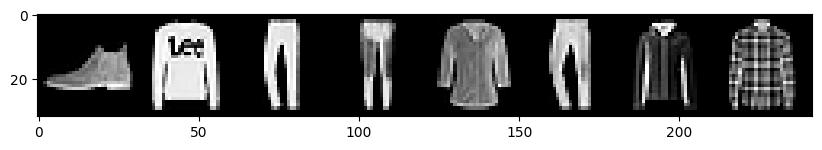

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35403568..1.312912].


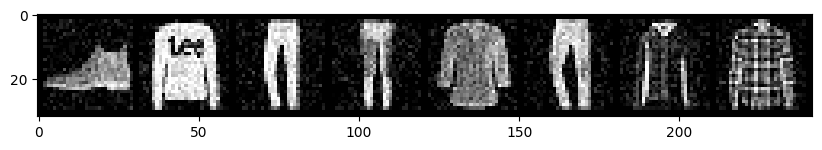

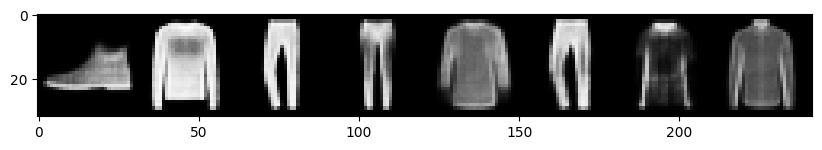

In [293]:
# plot results
n = 8
start = 0
# print(original_test_dataset.data[0])
ground_truth = original_test_dataset.data[start : start + n]
noisy = noisy_test_dataset.dataset.data[start : start + n]

x = [torch.unsqueeze(ground_truth[i], 0) for i in range(n)]
y = [test_dataset[i][0] for i in range(n)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(y))
plt.show()


noisy = noisy.float() / 255.0
noisy = noisy.to(device)

model.eval()
inferred = model(noisy)
inferred = inferred.cpu().detach()
z = [torch.unsqueeze(inferred[i].reshape(28, 28), 0) for i in range(n)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(z))
plt.show()
# plt.figure(figsize=(10,10))
# show(torchvision.utils.make_grid(y))
# plt.show()

# infered = model(noisy[0])

# Task 3: Model Selection

Conduct at least **3 experiments** for **each** of the previous tasks and document them (i.e. at least 6 experiments).  
Evaluate the effect of different parameters on the classification and denoising tasks.  
Conduct the following experiments:
- Evaluate the effect of residual connections
- Evaluate the effect of the depth(number of layers)/width (number of channels or number of neurons) of the network  
- Evaluate the effect of Batch normalization

## Optional experiments:
- How does the loss function affect denoising? Alternative loss functions: MSE, MAE, SSIM?
- How does Dropout affect the performance?
- Use different downsampling/upsampling layers, e.g.pooling, strided convolution, transposed convolution, etc.  
- Feel free to explore more variations of your model and training.